<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Tue Dec 16 21:11:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 591.44                 Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   35C    P8             29W /  320W |    1478MiB /  16376MiB |     10%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

2.9.1+cu128


'cuda'

## 1. What are 3 areas in industry where computer vision is currently being used?

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [64]:
import torchvision

from pathlib import Path
ws = Path.cwd()
MNIST_path = ws.parent.parent / 'data' 
dataset_train = torchvision.datasets.MNIST(MNIST_path.as_posix(), train=True, download=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST(MNIST_path.as_posix(), train=False, download=True, transform=torchvision.transforms.ToTensor())

## 6. Visualize at least 5 different samples of the MNIST training dataset.

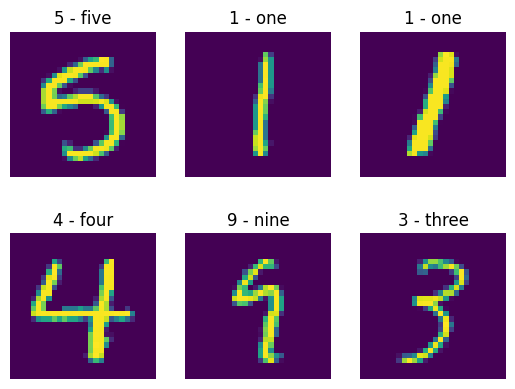

In [65]:
n_cls = len(dataset_train.classes)
import matplotlib.pyplot as plt
plt.figure()
nrows = 2
ncols = 3
n = 6
for i in range(n):
    rand = torch.randint(0, len(dataset_train), [1]).item()
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(dataset_train.data[rand])
    plt.title(dataset_train.classes[dataset_train.targets[rand]])
    plt.axis("Off")
plt.show()

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [66]:
BATCH_SIZE = 32
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [38]:
class digitModel(torch.nn.Module):
    def __init__(self, W:int, H:int, C: int, n_cls: int, hidden:int = 10,):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=C, out_channels=hidden, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        new_W, new_H = ((W - 2 - 2) // 2 -2 -2 ) //2, ((H - 2 - 2) // 2 -2 -2 ) //2
        self.detector = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=hidden * new_H * new_W, out_features=n_cls),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.detector(self.layer2(self.layer1(x)))

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [62]:

from tqdm.auto import tqdm
from timeit import default_timer
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def train_step(model:torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               optim:torch.optim.Optimizer, 
               loss_fn:torch.nn.Module, 
               acc_fn,
               device: str):
    train_loss = 0
    train_acc = 0
    model.to(device)
    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        model.train()
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += acc_fn(y_pred.argmax(dim=1), y)

        optim.zero_grad()

        loss.backward()
        optim.step()

    print(f'Training Loss: {train_loss/len(dataloader):.5f} || Training Accuracy: {train_acc/len(dataloader):.5f}.')

def test_step(model:torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               acc_fn,
               device: str):
    test_loss = 0
    test_acc = 0
    model.to(device)
    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        model.eval()
        with torch.inference_mode():
            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            test_loss += loss
            test_acc += acc_fn(y_pred.argmax(dim=1), y)


    print(f'Test Loss: {test_loss/len(dataloader):.5f} || Test Accuracy: {test_acc/len(dataloader):.5f}.')

W, H = train_dataloader.dataset.data.shape[1:]
model0 = digitModel(W,H,1,n_cls)
optim = torch.optim.Adam(model0.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()


start_time = default_timer()
for i in tqdm(range(5)):
    print(f"Epoch: {i} \n --------")
    train_step(model0, train_dataloader, optim, loss_fn, accuracy_fn, device)
    
end_time = default_timer()

print(f'Time taken {end_time - start_time}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 
 --------


 20%|██        | 1/5 [00:07<00:30,  7.67s/it]

Training Loss: 1.58157 || Training Accuracy: 88.15833.
Epoch: 1 
 --------


 40%|████      | 2/5 [00:15<00:22,  7.63s/it]

Training Loss: 1.51071 || Training Accuracy: 95.18500.
Epoch: 2 
 --------


 60%|██████    | 3/5 [00:23<00:15,  7.68s/it]

Training Loss: 1.50241 || Training Accuracy: 96.09667.
Epoch: 3 
 --------


 80%|████████  | 4/5 [00:30<00:07,  7.46s/it]

Training Loss: 1.49765 || Training Accuracy: 96.58333.
Epoch: 4 
 --------


100%|██████████| 5/5 [00:37<00:00,  7.41s/it]

Training Loss: 1.49443 || Training Accuracy: 96.76000.
Time taken 37.06830320000881


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

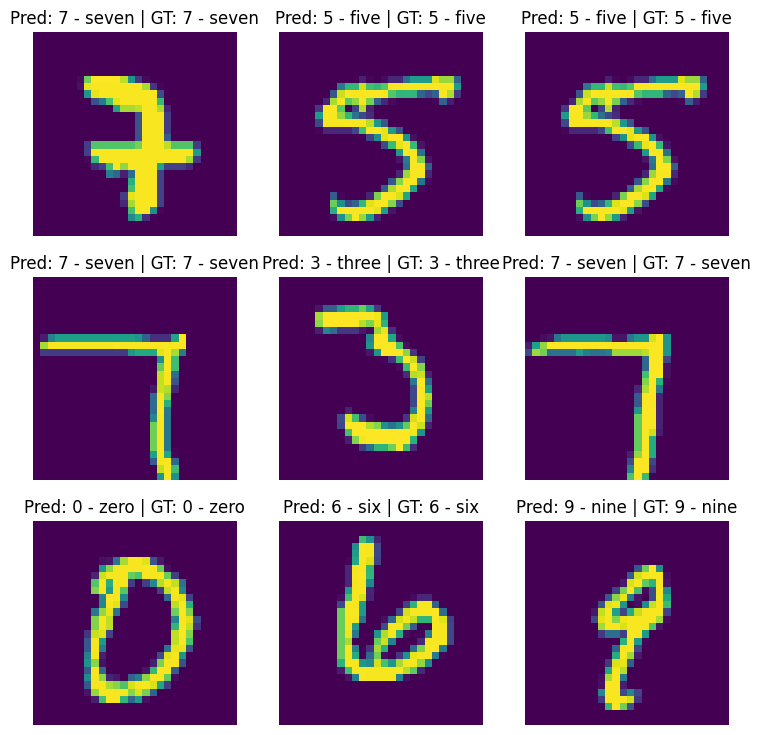

In [61]:
nrows = 3
ncols = 3
rand_indices = torch.randint(0, len(test_dataloader), [nrows*ncols]).tolist()

plt.figure(figsize=(9, 9))
for i in range(nrows * ncols):
    plt.subplot(nrows, ncols, i+1)

    x, y = dataset_test[rand_indices[i]]
    x = x.unsqueeze(dim=0).to(device)
    model0.to(device)

    y_pred = model0(x)
    y_label = dataset_test.classes[y_pred.argmax(dim=1).int()]
    plt.imshow(x.squeeze().cpu())

    plt.title(f'Pred: {y_label} | GT: {dataset_test.classes[y]}')
    plt.axis('Off')


## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

tensor([[ 975,    1,    1,    0,    0,    0,    1,    1,    1,    0],
        [   0, 1121,    6,    3,    0,    2,    1,    0,    2,    0],
        [   2,    2, 1016,    1,    2,    0,    0,    8,    1,    0],
        [   1,    0,   10,  982,    0,    4,    0,   10,    2,    1],
        [   3,    3,    8,    0,  945,    0,    1,    2,    2,   18],
        [   3,    0,    1,   16,    0,  866,    3,    1,    1,    1],
        [  11,    2,    2,    2,    2,    6,  933,    0,    0,    0],
        [   0,    2,   19,    2,    0,    0,    0,  999,    1,    5],
        [  10,    0,    7,   10,    6,    5,    2,    5,  919,   10],
        [   2,    9,    6,    7,    6,   10,    0,    5,    1,  963]])


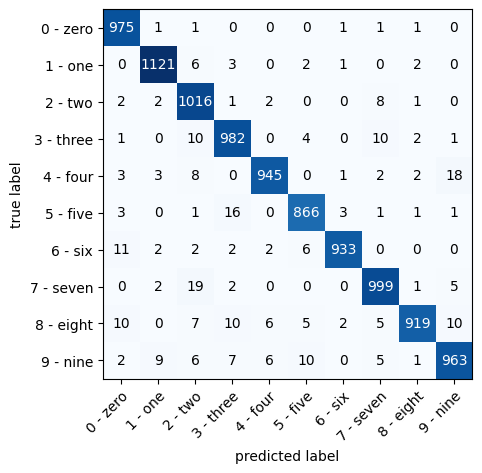

In [75]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
def evaluate_model(model: torch.nn.Module , dataloader: torch.utils.data.DataLoader, device:str):
    model.to(device)
    pred_results = []
    gt_results = []
    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        model.eval()
        with torch.inference_mode():
            y_pred = model(x)
            pred_result = y_pred.argmax(dim=1)
            pred_results.append(pred_result)
            gt_results.append(y)

            assert pred_result.shape == y.shape
    
    pred = torch.cat(pred_results)
    gt = torch.cat(gt_results)

    return pred, gt

confusion = ConfusionMatrix(task="multiclass", num_classes=len(dataset_test.classes))

pred, gt = evaluate_model(model0, test_dataloader, device)
# print(pred[:5])
# print(gt[:5])
mat = confusion(pred.cpu(), gt.cpu())
print(mat)
fig, ax = plot_confusion_matrix(mat.numpy(), class_names=dataset_test.classes)


## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?